In [16]:
import pandas as pd

# Load the Parquet file
df = pd.read_parquet("gps_data_relaxed_parameters.parquet")

# Show first few rows
print(df.head())

# Show column names and data types
print(df.info())


   id_tracking        id                time  type  sequence comment  speed  \
0        79176  92799397 2023-04-26 11:37:47     0      1061    None    0.0   
1        79176  92799398 2023-04-26 11:37:49     0      1062    None    0.0   
2        79176  92799399 2023-04-26 11:37:49    33      1063    None    0.0   
3        79176  92799400 2023-04-26 11:37:49    33      1064    None    0.0   
4        79176  92799401 2023-04-26 11:37:50    33      1065    None    0.0   

   heading  duration  block_type   log   latitude  longitude  altitude  \
0      0.0         0           0  None  47.482827   9.758895       0.0   
1      0.0         0           0  None  47.482928   9.758692       0.0   
2      0.0         0           0  None  47.482928   9.758692       0.0   
3      0.0         0           0  None  47.482928   9.758692       0.0   
4      0.0         0           0  None  47.482940   9.758615       0.0   

   meta_tag meta_value  
0         0             
1         0             
2    

In [17]:
print(df.describe())


         id_tracking            id                           time  \
count   92147.000000  9.214700e+04                          92147   
mean    60043.275733  7.350316e+07  2022-04-22 19:20:38.814578688   
min        71.000000  8.060300e+04            2014-07-08 00:00:00   
25%     34264.000000  4.735328e+07            2021-01-13 07:13:43   
50%     72064.000000  8.565947e+07            2023-02-01 07:09:28   
75%     82413.000000  9.798122e+07     2023-12-21 14:15:59.500000   
max    101287.000000  1.276973e+08            2025-03-03 13:11:20   
std     29437.464040  3.401519e+07                            NaN   

               type      sequence    speed  heading  duration  block_type  \
count  92147.000000  92147.000000  92147.0  92147.0   92147.0     92147.0   
mean       5.639999    186.671026      0.0      0.0       0.0         0.0   
min        0.000000      0.000000      0.0      0.0       0.0         0.0   
25%        0.000000     58.000000      0.0      0.0       0.0         

In [18]:
print(df.isnull().sum())


id_tracking        0
id                 0
time               0
type               0
sequence           0
comment        92147
speed              0
heading            0
duration           0
block_type         0
log            92147
latitude           0
longitude          0
altitude           0
meta_tag           0
meta_value         0
dtype: int64


In [19]:
waypoints_per_tracking = df.groupby("id_tracking").size()
print(waypoints_per_tracking.describe())  


count     399.000000
mean      230.944862
std       180.798819
min        11.000000
25%       148.000000
50%       194.000000
75%       267.000000
max      2258.000000
dtype: float64


In [20]:
avg_speed_per_tracking = df.groupby("id_tracking")["speed"].mean()
print(avg_speed_per_tracking.describe())


count    399.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: speed, dtype: float64


In [21]:
import numpy as np

# Compute rough distance traveled using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = phi2 - phi1
    dlambda = np.radians(lon2 - lon1)
    
    a = np.sin(dphi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

# Compute distance per row
df['prev_lat'] = df.groupby("id_tracking")['latitude'].shift(1)
df['prev_lon'] = df.groupby("id_tracking")['longitude'].shift(1)

df['distance_km'] = df.apply(lambda row: haversine(row.prev_lat, row.prev_lon, row.latitude, row.longitude)
                             if pd.notnull(row.prev_lat) else 0, axis=1)

# Aggregate distance per tracking
total_distance_per_tracking = df.groupby("id_tracking")["distance_km"].sum()
print(total_distance_per_tracking.describe())


count    399.000000
mean      17.534675
std       12.273421
min        0.863608
25%        9.444987
50%       13.951097
75%       21.893396
max      121.898045
Name: distance_km, dtype: float64


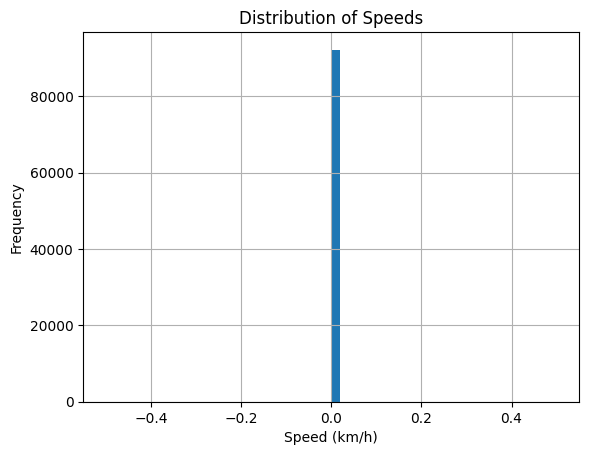

In [22]:
import matplotlib.pyplot as plt

df["speed"].hist(bins=50)
plt.xlabel("Speed (km/h)")
plt.ylabel("Frequency")
plt.title("Distribution of Speeds")
plt.show()


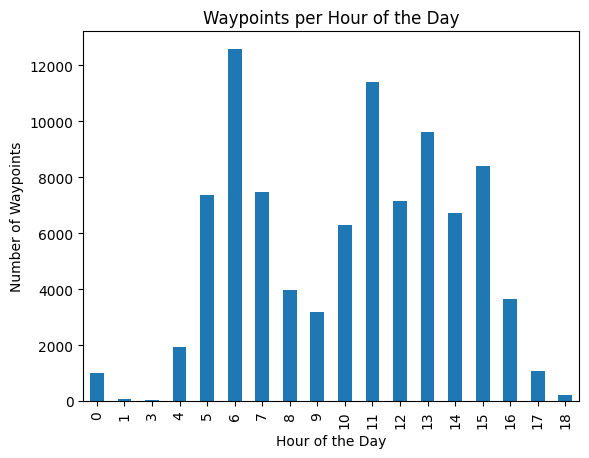

In [23]:
df['hour'] = pd.to_datetime(df['time']).dt.hour
df['hour'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Waypoints")
plt.title("Waypoints per Hour of the Day")
plt.show()


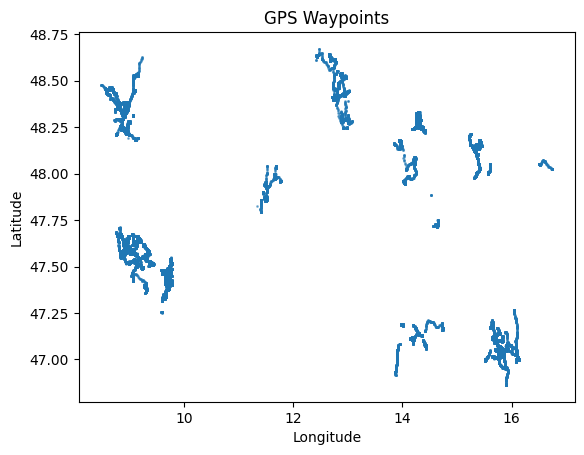

In [24]:
plt.scatter(df["longitude"], df["latitude"], alpha=0.5, s=1)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("GPS Waypoints")
plt.show()
